In [1]:
import gymnasium as gym
import highway_env
import numpy as np
import matplotlib.pyplot as plt

# Create the highway environment
env = gym.make("highway-v0", render_mode="rgb_array")

# Configure the environment
env.configure({
    "observation": {"type": "Kinematics"},
    "duration": 40,
    "vehicles_count": 15,
    "collision_reward": -1.0,
    "reward_speed_range": [20, 30],
    "offroad_terminal": False
})

obs, info = env.reset()

print("Observation shape:", obs.shape)
print("Action space:", env.action_space)  # Discrete(5)

# Access the underlying action type object:
act_type = env.unwrapped.action_type
print("Action indexes:", act_type.actions_indexes)
# e.g. {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}

Observation shape: (5, 5)
Action space: Discrete(5)
Action indexes: {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


Episode ended at step 32
Total reward: 26.16
Captured 32 frames


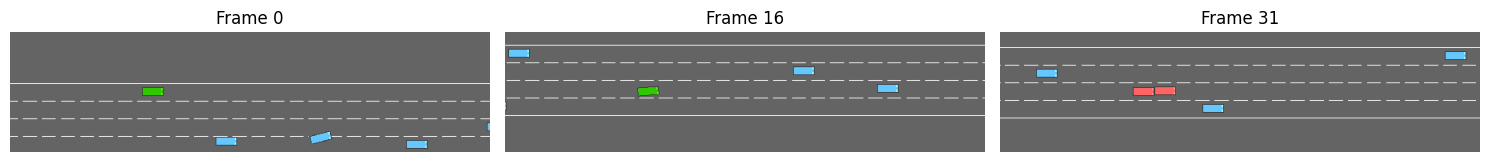

: 

In [ ]:
# Run a simple episode with random actions and visualize
episode_steps = 50
frames = []
total_reward = 0

obs, info = env.reset()

for step in range(episode_steps):
    # Take a random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    
    total_reward += reward
    
    # Capture frame for visualization
    frame = env.render()
    frames.append(frame)
    
    if terminated or truncated:
        print(f"Episode ended at step {step + 1}")
        break

print(f"Total reward: {total_reward:.2f}")
print(f"Captured {len(frames)} frames")

# Display some frames
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
indices = [0, len(frames)//2, -1]
for idx, ax in zip(indices, axes):
    ax.imshow(frames[idx])
    ax.set_title(f"Frame {idx if idx >= 0 else len(frames) + idx}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Train DQN Agent

Now we'll train a Deep Q-Network (DQN) agent using Stable Baselines3 and track the discounted returns over episodes.

In [2]:
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

# Custom callback to track episode rewards and compute discounted returns
class RewardCallback(BaseCallback):
    def __init__(self, gamma=0.95, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.gamma = gamma
        self.episode_rewards = []
        self.episode_lengths = []
        self.current_rewards = []
        
    def _on_step(self) -> bool:
        # Check if episode ended
        if self.locals.get("dones")[0]:
            # Calculate discounted return for the episode
            episode_reward = sum(self.current_rewards)
            discounted_return = sum([r * (self.gamma ** i) for i, r in enumerate(self.current_rewards)])
            
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(len(self.current_rewards))
            
            if self.verbose > 0:
                print(f"Episode {len(self.episode_rewards)}: "
                      f"Length={len(self.current_rewards)}, "
                      f"Reward={episode_reward:.2f}, "
                      f"Discounted={discounted_return:.2f}")
            
            self.current_rewards = []
        
        # Store current step reward
        reward = self.locals.get("rewards")[0]
        self.current_rewards.append(reward)
        
        return True

# Create a fresh environment for training
train_env = gym.make("highway-v0", render_mode="rgb_array")
train_env.configure({
    "observation": {"type": "Kinematics"},
    "duration": 40,
    "vehicles_count": 15,
    "collision_reward": -1.0,
    "reward_speed_range": [20, 30],
    "offroad_terminal": False
})

# Initialize callback
gamma = 0.95
callback = RewardCallback(gamma=gamma, verbose=1)

print("Training DQN agent...")
print("This may take a few minutes...")

# Create and train DQN model
model = DQN(
    "MlpPolicy",
    train_env,
    learning_rate=5e-4,
    buffer_size=15000,
    learning_starts=200,
    batch_size=32,
    gamma=gamma,
    train_freq=1,
    gradient_steps=1,
    target_update_interval=50,
    exploration_fraction=0.3,
    exploration_final_eps=0.01,
    verbose=0
)

# Train the model
total_timesteps = 15000
model.learn(total_timesteps=total_timesteps, callback=callback)

print(f"\nTraining complete! Trained for {len(callback.episode_rewards)} episodes")

/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/resource_handle.proto. Please update the gencode

Training DQN agent...
This may take a few minutes...
Episode 1: Length=6, Reward=4.60, Discounted=4.07
Episode 2: Length=18, Reward=14.73, Discounted=9.46
Episode 3: Length=10, Reward=7.73, Discounted=6.01
Episode 4: Length=11, Reward=8.46, Discounted=6.48
Episode 5: Length=23, Reward=17.78, Discounted=10.45
Episode 6: Length=31, Reward=21.93, Discounted=11.10
Episode 7: Length=16, Reward=11.10, Discounted=7.62
Episode 8: Length=5, Reward=3.84, Discounted=3.38
Episode 9: Length=3, Reward=1.93, Discounted=1.79
Episode 10: Length=4, Reward=2.73, Discounted=2.48
Episode 11: Length=21, Reward=16.79, Discounted=10.09
Episode 12: Length=10, Reward=6.63, Discounted=5.21
Episode 13: Length=9, Reward=7.12, Discounted=5.67
Episode 14: Length=2, Reward=0.91, Discounted=0.87
Episode 15: Length=7, Reward=4.96, Discounted=4.20
Episode 16: Length=10, Reward=6.83, Discounted=5.38
Episode 17: Length=2, Reward=0.84, Discounted=0.80
Episode 18: Length=18, Reward=14.56, Discounted=9.60
Episode 19: Length=

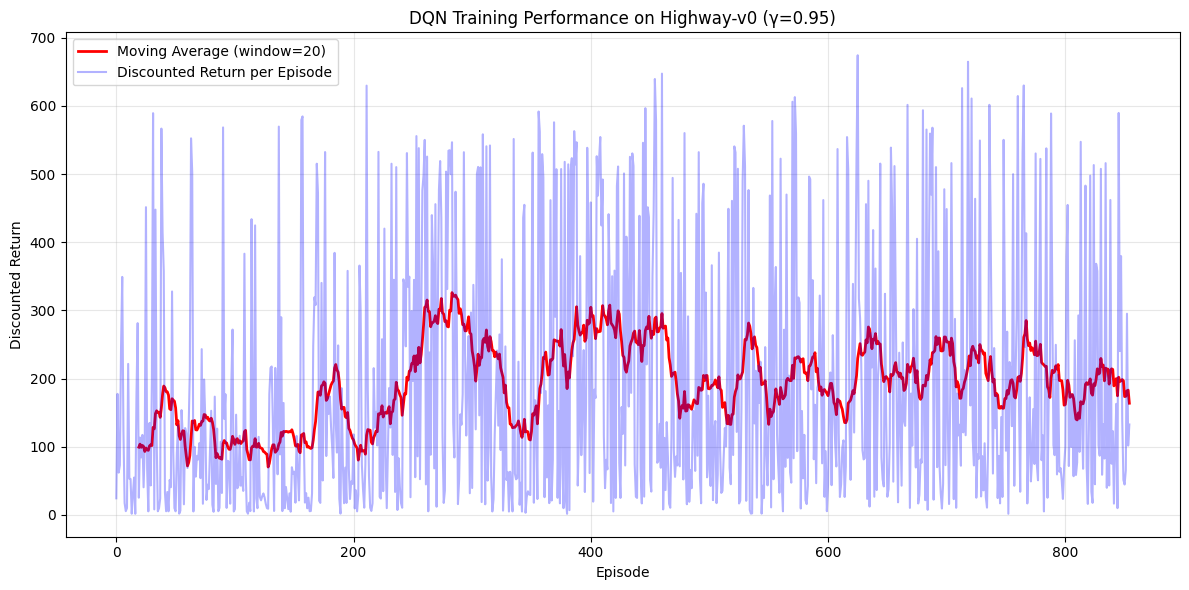


Training Statistics:
Total episodes: 855
Average discounted return: 191.14
Final 10 episodes avg: 203.94
Best discounted return: 674.19


In [3]:
# Calculate discounted returns for all episodes
discounted_returns = []
for ep_rewards in [callback.current_rewards]:  # Not used, will recalculate from stored data
    pass

# Recalculate discounted returns from episode rewards
# (Approximation: using total episode rewards with discount factor)
discounted_returns = []
for i, ep_reward in enumerate(callback.episode_rewards):
    ep_length = callback.episode_lengths[i]
    # Approximate discounted return using geometric series
    discounted_ret = ep_reward * (1 - gamma**ep_length) / (1 - gamma) if gamma < 1 else ep_reward * ep_length
    discounted_returns.append(discounted_ret)

# Plot discounted returns
plt.figure(figsize=(12, 6))

# Moving average
window = 20
if len(discounted_returns) >= window:
    moving_avg = np.convolve(discounted_returns, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(discounted_returns)), moving_avg, 
             label=f'Moving Average (window={window})', color='red', linewidth=2)

plt.plot(discounted_returns, alpha=0.3, label='Discounted Return per Episode', color='blue')
plt.xlabel('Episode')
plt.ylabel('Discounted Return')
plt.title(f'DQN Training Performance on Highway-v0 (γ={gamma})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTraining Statistics:")
print(f"Total episodes: {len(discounted_returns)}")
print(f"Average discounted return: {np.mean(discounted_returns):.2f}")
print(f"Final 10 episodes avg: {np.mean(discounted_returns[-10:]):.2f}")
print(f"Best discounted return: {np.max(discounted_returns):.2f}")

## Evaluate Trained Agent

Let's visualize how the trained DQN agent performs compared to random actions.

/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


Running trained DQN agent...
Episode ended at step 10
Total reward: 7.73
Discounted return: 6.32
Episode length: 10 steps


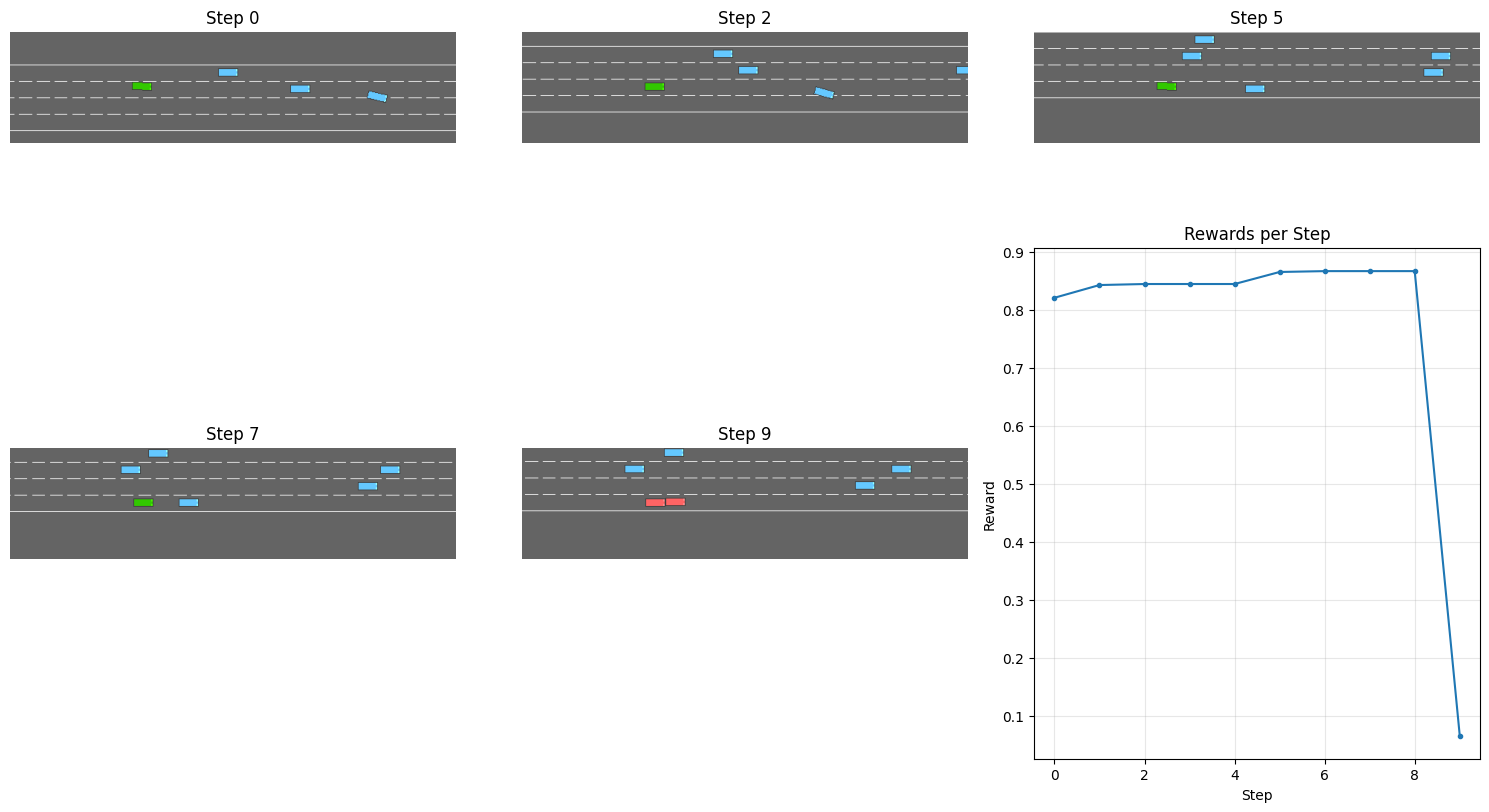

: 

In [ ]:
# Evaluate the trained agent
eval_env = gym.make("highway-v0", render_mode="rgb_array")
eval_env.configure({
    "observation": {"type": "Kinematics"},
    "duration": 40,
    "vehicles_count": 15,
    "collision_reward": -1.0,
    "reward_speed_range": [20, 30],
    "offroad_terminal": False
})

obs, info = eval_env.reset()
eval_frames = []
eval_rewards = []
total_reward = 0

print("Running trained DQN agent...")
for step in range(100):
    # Use trained model to predict action
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    
    eval_rewards.append(reward)
    total_reward += reward
    
    # Capture frame
    frame = eval_env.render()
    eval_frames.append(frame)
    
    if terminated or truncated:
        print(f"Episode ended at step {step + 1}")
        break

# Calculate discounted return
discounted_eval_return = sum([r * (gamma ** i) for i, r in enumerate(eval_rewards)])

print(f"Total reward: {total_reward:.2f}")
print(f"Discounted return: {discounted_eval_return:.2f}")
print(f"Episode length: {len(eval_rewards)} steps")

# Visualize evaluation
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
indices = [0, len(eval_frames)//4, len(eval_frames)//2, 3*len(eval_frames)//4, -1]
for idx, ax in zip(indices[:5], axes.flat[:5]):
    ax.imshow(eval_frames[idx if idx >= 0 else len(eval_frames) + idx])
    ax.set_title(f"Step {idx if idx >= 0 else len(eval_frames) + idx}")
    ax.axis('off')

# Plot rewards over time in the 6th subplot
axes.flat[5].plot(eval_rewards, marker='o', markersize=3)
axes.flat[5].set_xlabel('Step')
axes.flat[5].set_ylabel('Reward')
axes.flat[5].set_title('Rewards per Step')
axes.flat[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()